In [42]:
%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib as mpl
import h5py
import numpy as np
import json

In [43]:
def projectDistZ(x1,x2,y1,y2,d12,z):
    mx = (x2-x1)/d12
    xProj = x1 + mx * z
    
    my = (y2-y1)/d12
    yProj = y1 + my * z
    
    return (xProj, yProj)

def get_theta_angles(x1, y1, x2, y2, d):
    import numpy as np
    thetaX = np.arctan((x2-x1)/d) #rad
    thetaY = np.arctan((y2-y1)/d) #rad
    return (thetaX, thetaY)


def file_loader(runs):
    """
    Load the data file for a given run number.
    """
    from collections.abc import Iterable
    
    if not isinstance(runs, Iterable):
        runs = [runs]

    pos = []
    infos = []
    phs = []
    tmis = []
    evis =[]
    nclus = []
    info_pluss =[]
    bases = []
    for run_number in runs:
        data_path =f'../data/TB_T9_2025/run{run_number}.h5'
        # data_path =f'/eos/project/i/insulab-como/testBeam/TB_2025_06_T9_epBOOST/HDF5/run{run_number}.h5'
        print('\nopening ', data_path)
        pos = []
        phs = []
        tmis =[]
        qtots =[]
        nclus = []
        info_pluss =[]
        xinfos =[]
        with h5py.File(data_path, 'r', libver='latest', swmr=True) as hf:
            # print(hf.keys())
            hf["xpos"].shape
            keys = list(hf.keys())
            pos.append(np.array(hf['xpos']))
            phs.append(np.array(hf['digiPH'])) # from 24
            tmis.append(np.array(hf['digiTime'])) # from 24
            qtots.append(np.array(hf['qtot'])) # from 24
            nclus.append(np.array(hf['nclu'])) # from 24
            info_pluss.append(np.array(hf['info_plus']))
            xinfos.append(np.array(hf['xinfo']))
            #for k in hf.keys():
            #    comand = f'{k} = np.array(hf["{k}"])'
                # print(comand)
            #  exec(comand)
            # print(len(pos))
    xpos = np.concatenate(pos,axis=0)
    ph = np.concatenate(phs,axis=0)
    tm = np.concatenate(tmis,axis=0)
    qtot = np.concatenate(qtots,axis=0)
    nclu = np.concatenate(nclus,axis=0)
    info_plus = np.concatenate(info_pluss,axis=0)
    xinfo = np.concatenate(xinfos,axis=0)
    # print('xpos shape', xpos.shape)
    
    # print(np.unique(xinfo[:,1]))
        # print('xpos shape', xpos.shape)

    xpos[:,2]= xpos[:,2] - offset_x2 
    xpos[:,3]= xpos[:,3] - offset_y2 
    
    x1 = xpos[:,0]
    y1 = xpos[:,1]
    x2 = xpos[:,2] 
    y2 = xpos[:,3] 
    x3 = xpos[:,4]
    y3 = xpos[:,5]


    Calibration = False
    if Calibration:
        q = -25.84
        m = 323.4
        ph[:,2]=  (ph[:,2] - q)/m

    xcry, ycry = projectDistZ(x1,x2,y1,y2,d12,d1c)
    theta_x_in, theta_y_in = get_theta_angles(x1, y1, x2, y2, d12)
    theta_x_out, theta_y_out = get_theta_angles(xcry, ycry, x3, y3, dc3)


    ph_calo_photon = ph[:,2]
    ph_cherry1 = ph[:,0]
    print(f'{runs} -- N spill: {info_plus[:,0][-1]} -- events: {len(ph_calo_photon)} -- evs/spill: {len(ph_calo_photon)/info_plus[:,0][-1]:.0f}')
    return xpos, x1, y1, x2, y2, x3, y3, xcry, ycry, ph_calo_photon, ph_cherry1, \
    theta_x_in, theta_y_in, theta_x_out, theta_y_out, tm, qtot, nclu, info_plus,xinfo


In [44]:
d12 = 330 ## cm
d23 = 66.8
d1c = 330 + 53.2 #cm
dc3 = 10.7 
d1calo = d1c + 779.2 

offset_x2 =   -0.19494474108211143
offset_y2 =   2.276578722633391 

range_chamber = ((0,10),(0,10))
bins2d = (100,100)
mycmap = 'jet'

opt_hist = {'histtype': 'step', 'lw': 1.5, 'alpha': 0.8}
opts_2d = { "cmap" : mycmap, "bins" : bins2d} # "norm" : mpl.colors.LogNorm()}

th_cherry1 = 20
th_cherry2 = 20


In [45]:
with open('mutiple_run.json', 'r') as file:
    run_config = json.load(file)

scan_number = run_config.get("scan_number") 
label_scan = run_config.get("scan_labels")
print(f"Run numbers: {scan_number}")

Run numbers: [730245, 730224]


In [ ]:

# x_cry_cut = [4.6, 4.9]
# y_cry_cut = [4.7, 5.15]
# if any(run in scan_number for run in [730223, 730224, 730227, 730225, 730228, 730229, 730230]):
x_cry_cut = [4.6, 4.9]
y_cry_cut = [4.7, 5.15]

isrot = False
iscrad = True
opt_hist = dict(histtype='step', linewidth=1.5)

fig, axs = plt.subplots(2, 3, figsize=(14, 8), sharey=False)
axs = axs.flatten()  # Makes indexing easier (axs[0] to axs[5])

for run in scan_number:
    xpos,x1, y1, x2, y2, x3, y3, xcry, ycry, ph_calo_photon, ph_cherry1, \
    theta_x_in, theta_y_in, theta_x_out, theta_y_out, tm, qtot, nclu, info_plus, xinfo = file_loader(run)

    if iscrad:
        scan_angle = xinfo[:, 1]
    else:
        scan_angle = xinfo[:, 0]

    unique_steps = np.unique(scan_angle)
    print(f'unique step values {unique_steps}')
    n_steps = len(unique_steps)

    for i, step in enumerate(unique_steps):
        logi = (ph_cherry1 > th_cherry1) & \
               (scan_angle == step) & \
               (xcry > x_cry_cut[0]) & (xcry < x_cry_cut[1]) & \
               (ycry > y_cry_cut[0]) & (ycry < y_cry_cut[1])

        if np.sum(logi) == 0:
            continue

        axs[0].hist(ph_calo_photon[logi], bins=20, range=(0, 3000), label=f'Step {step:.0f} -- {np.mean(ph_calo_photon[logi]):.2f}', density=True, **opt_hist)
        axs[1].hist(qtot[:, 0][logi], bins=50, range=(0, 5000), label=f'Step {step:.0f} -- {np.mean(qtot[:, 0][logi]):.2f}', density=True, **opt_hist)
        axs[2].hist(nclu[:, 0][logi], bins=50, label=f'Step {step:.0f} -- {np.mean(nclu[:, 0][logi]):.2f}', density=True, **opt_hist)
        axs[3].hist(x3[logi], bins=20,range = (4,6), label=f'Step {step:.0f}', density=True, **opt_hist)
        axs[4].hist(y3[logi], bins=20,range = (4,6), label=f'Step {step:.0f}', density=True, **opt_hist)

# Titoli
axs[0].set_title(f'scan: {scan_number[0]}–{scan_number[-1]}\nCalo Photon PH')
axs[1].set_title('qtot[0]')
axs[2].set_title('nclu[0]')
axs[3].set_title('x3')
axs[4].set_title('y3')

# Assi e scala log
labels = ['Calo PH [ADC]', 'qtot[0] [ADC]', 'nclu[0]', 'x3 [mm]', 'y3 [mm]']
for j in range(3):
    axs[j].set_xlabel(labels[j])
    axs[j].set_ylabel('Counts')
    axs[j].set_yscale('log')
    axs[j].legend()  # enable if needed

plt.tight_layout()
plt.show()



opening  ../data/TB_T9_2025/run730245.h5
[730245] -- N spill: 332 -- events: 31752 -- evs/spill: 96
unique step values [36000.035]

opening  ../data/TB_T9_2025/run730224.h5



opening  ../data/TB_T9_2025/run730245.h5
[730245] -- N spill: 310 -- events: 29624 -- evs/spill: 96

opening  ../data/TB_T9_2025/run730224.h5
[730224] -- N spill: 1334 -- events: 194507 -- evs/spill: 146


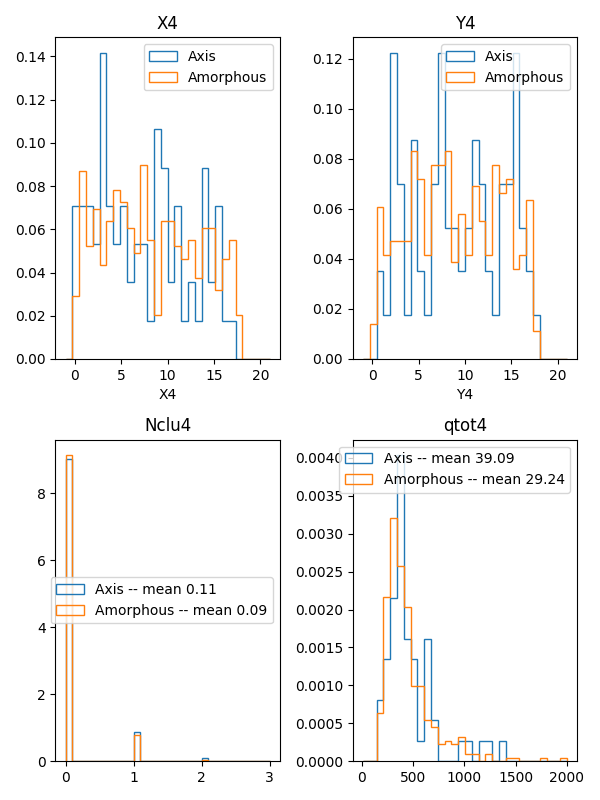

In [ ]:
fig, ax = plt.subplots(2,2, figsize = (6,8))
iWantDensity = True
for i, run in enumerate(scan_number):
    if run >730198:
        xpos, x1, y1, x2, y2, x3, y3, xcry, ycry, ph_calo_photon, ph_cherry1, \
        theta_x_in, theta_y_in, theta_x_out, theta_y_out, tm, qtot, nclu, info_plus, xinfo = file_loader(run)

        mask = (ph_cherry1 > th_cherry1) & \
           (xcry > x_cry_cut[0]) & (xcry < x_cry_cut[1]) & \
           (ycry > y_cry_cut[0]) & (ycry < y_cry_cut[1])
        ax = ax.flatten()
        x4 = xpos[:,6]
        y4 = xpos[:,7]


        ax[0].hist(x4[mask], bins = 30, range = (-1,21), histtype = 'step', density = iWantDensity, label = label_scan[i])
        ax[0].set_title('X4')
        ax[0].set_xlabel('X4')
        ax[1].hist(y4[mask], bins = 30, range = (-1,21), histtype = 'step', density = iWantDensity,label = label_scan[i])
        ax[1].set_title('Y4')
        ax[1].set_xlabel('Y4')

        ax[2].hist(nclu[:,2][mask], bins = 30, histtype = 'step', density = iWantDensity,label = f'{label_scan[i]} -- mean {np.mean(nclu[:,2][mask]):.2f}')
        # ax[2].hist(nclu[:,3][mask], bins = 30, histtype = 'step')
        ax[2].set_title('Nclu4')

        ax[3].hist(qtot[:,2][mask], bins = 30, range = (10,2000), histtype = 'step', density = iWantDensity, label = f'{label_scan[i]} -- mean {np.mean(qtot[:,2][mask]):.2f}')
        # ax[3].hist(qtot[:,3][mask], bins = 30, range = (10,2000), histtype = 'step')
        ax[3].set_title('qtot4')
        
for a in ax:
    a.legend()
        
plt.tight_layout()
plt.show()